Ga naar Chrome en zoek in Google images naar plaatjes van bijv katten.
Ga naar advanced search en zoek naar .png files van medium grootte

Druk op ctrl+shift+J in Chrome en copy paste deze javascript code
Deze code zoekt naar alle urls en zet ze in een bestandje onder elkaar, gescheiden door newlines (\n)

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```
Druk op Enter

In [1]:
# imports voor python
import urllib.request 
import uuid
import os
from PIL import Image, ImageFile
from shutil import copyfile
import random

# our high level variables
training_images_per_class = 256
test_images_per_class = 64
basepath='C:/test/classifier/dataset'

# create the download path for picture files
basepath_download = f'{basepath}/download'
os.makedirs(basepath_download, exist_ok=True)

# create single prediction path
basepath_single_prediction = f'{basepath}/single_prediction' 
os.makedirs(basepath_single_prediction, exist_ok=True)
    
# find the classes to be downloaded
class_names = []
for file in os.listdir(basepath_download):
    class_names.append(file)
print (f'I will download the classes: {class_names}')

I will download the classes: ['cat', 'tree']


In [2]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

print (f'Proceeding to download {class_names} images at best effort :-)')
print (f'I will download {training_images_per_class} training images and {test_images_per_class} test images per class, totalling {training_images_per_class + test_images_per_class} images')
print ('------------------------------------------')
for class_name in class_names:
    print ('')
    print (f'Downloading {class_name}')
    print ('------------------------------------------')
    # open the downloaded chrome file with all the urls
    f=open(f'{basepath_download}/{class_name}','r')

    # Make sure training and test sub paths exist. 
    # Careful, if you execute this code twice it will simply add new files. Old files will not be deleted
    basepath_training = f'{basepath}/training_set/{class_name}' 
    os.makedirs(basepath_training, exist_ok=True)

    basepath_test = f'{basepath}/test_set/{class_name}' 
    os.makedirs(basepath_test, exist_ok=True)

    # download each file
    count = len(os.listdir(basepath_training)) + len(os.listdir(basepath_test))
    print (f'Previously already downloaded {count} images')
    for url in f:
        # limit to xxx images, download extra images for testing purposes
        if count>=training_images_per_class+test_images_per_class:
            break;

        # check where to download the image to
        new_uuid = uuid.uuid4()
        type_download = ''
        if count+1<= training_images_per_class:
            filename = f'{basepath_training}/{new_uuid}.png' 
            type_download = 'training'
        else:
            filename = f'{basepath_test}/{new_uuid}.png' 
            type_download = 'test'

        # the actual download. Make sure files are not corrupted
        try:
            # download the file
            urllib.request.urlretrieve(url, filename)

            # check if the file is ok
            img = Image.open(filename)
            img.verify()

            # for 20% of the test images, copy to single prediction
            if (type_download == 'test' and random.randint(0, 100)<20):
                sp_file = f'{basepath_single_prediction}/{new_uuid}.png' 
                copyfile(filename, sp_file)
                print ("single prediction copy included")

            count+= 1
            print (count, f"Downloaded and verified {class_name} in {type_download}")

        except Exception as e:
            # remove the corrupt file if it exists
            if os.path.isfile(filename):
                os.remove(filename)
            print (count, 'Failed to download', e, ':-(')

    print (f'Done downloading {class_name}! Total of {count} images')
    
print ('Done downloading everything, congratulations!!')

Proceeding to download ['cat', 'tree'] images at best effort :-)
I will download 256 training images and 64 test images per class, totalling 320 images
------------------------------------------

------------------------------------------
Previously already downloaded 320 images
Done downloading cat! Total of 320 images

------------------------------------------
Previously already downloaded 159 images
160 Downloaded and verified tree in training
161 Downloaded and verified tree in training
161 Failed to download HTTP Error 403: Forbidden :-(
162 Downloaded and verified tree in training
163 Downloaded and verified tree in training
164 Downloaded and verified tree in training
165 Downloaded and verified tree in training
166 Downloaded and verified tree in training
167 Downloaded and verified tree in training
167 Failed to download HTTP Error 403: Forbidden :-(
167 Failed to download HTTP Error 403: Forbidden :-(
168 Downloaded and verified tree in training
169 Downloaded and verified t

287 Downloaded and verified tree in test
288 Downloaded and verified tree in test
288 Failed to download HTTP Error 403: Forbidden :-(
289 Downloaded and verified tree in test
290 Downloaded and verified tree in test
291 Downloaded and verified tree in test
292 Downloaded and verified tree in test
293 Downloaded and verified tree in test
294 Downloaded and verified tree in test
single prediction copy included
295 Downloaded and verified tree in test
single prediction copy included
296 Downloaded and verified tree in test
297 Downloaded and verified tree in test
single prediction copy included
298 Downloaded and verified tree in test
single prediction copy included
299 Downloaded and verified tree in test
300 Downloaded and verified tree in test
301 Downloaded and verified tree in test
single prediction copy included
302 Downloaded and verified tree in test
single prediction copy included
303 Downloaded and verified tree in test
303 Failed to download HTTP Error 403: Forbidden :-(
304 D

In [3]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Initialising the CNN
classifier = Sequential() # simpel model met layers lineair achter elkaar
# Step 1 - Convolution
# change input_shape = (64, 64, 3) to input_shape = (64, 64, 1) for grayscale
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu')) 
# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a second convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier.add(Flatten())
# Step 4 - Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))
# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [4]:
# Part 2 - Fitting the CNN to the images
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(f'{basepath}/training_set', 
                                                 target_size = (64, 64), 
                                                 batch_size = 32, 
                                                 color_mode='rgb', # dit is veel langzamer dan grayscale
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory(f'{basepath}/test_set', 
                                            target_size = (64, 64), 
                                            batch_size = 32, 
                                            color_mode='rgb', # dit is veel langzamer dan grayscale
                                            class_mode = 'binary')
history = classifier.fit_generator(training_set, 
                         steps_per_epoch = training_images_per_class/32, # number of images per class / batch size
                         epochs = 10, # number of times you expose the full dataset to the neural network
                         validation_data = test_set,
                         validation_steps = test_images_per_class)

Found 512 images belonging to 2 classes.
Found 128 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10


C:\Users\mvanderuitenbeek\AppData\Local\Continuum\anaconda3\lib\site-packages\PIL\Image.py:952: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


8/8 [==============================] - 48s 6s/step - loss: 0.7323 - acc: 0.5586 - val_loss: 0.5444 - val_acc: 0.7656
Epoch 2/10
8/8 [==============================] - 47s 6s/step - loss: 0.5584 - acc: 0.7031 - val_loss: 0.4056 - val_acc: 0.8281
Epoch 3/10
8/8 [==============================] - 51s 6s/step - loss: 0.4500 - acc: 0.7891 - val_loss: 0.3513 - val_acc: 0.8750
Epoch 4/10
8/8 [==============================] - 50s 6s/step - loss: 0.3109 - acc: 0.8945 - val_loss: 0.5194 - val_acc: 0.7891
Epoch 5/10
8/8 [==============================] - 49s 6s/step - loss: 0.2660 - acc: 0.9023 - val_loss: 0.2314 - val_acc: 0.8984
Epoch 6/10
8/8 [==============================] - 48s 6s/step - loss: 0.2944 - acc: 0.8750 - val_loss: 0.3312 - val_acc: 0.8516
Epoch 7/10
8/8 [==============================] - 47s 6s/step - loss: 0.2122 - acc: 0.9336 - val_loss: 0.3741 - val_acc: 0.8516
Epoch 8/10
8/8 [==============================] - 45s 6s/step - loss: 0.2701 - acc: 0.8945 - val_loss: 0.3264 - val

[]

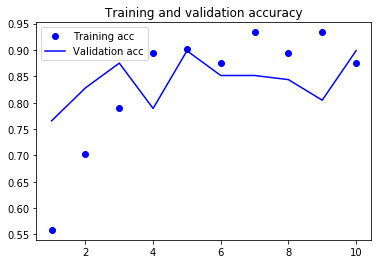

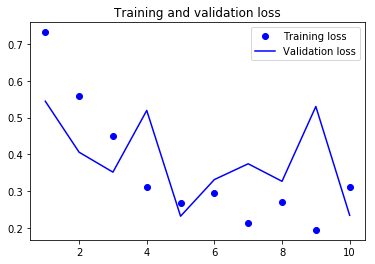

In [7]:
from matplotlib import pyplot as plt
# get results from training
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# plot the accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# plot the loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# print the result to screen
plt.plot()

I trained these classifications: {'cat': 0, 'tree': 1}


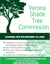

'I believe this is a tree'

----------------------------------


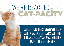

'I believe this is a cat'

----------------------------------


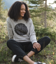

'I believe this is a tree'

----------------------------------


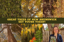

'I believe this is a tree'

----------------------------------


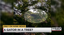

'no idea'

----------------------------------


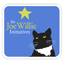

'I believe this is a cat'

----------------------------------


'I believe this is a tree'

----------------------------------


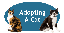

'I believe this is a tree'

----------------------------------


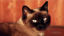

'I believe this is a cat'

----------------------------------


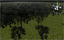

'I believe this is a tree'

----------------------------------


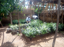

'I believe this is a tree'

----------------------------------


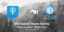

'I believe this is a tree'

----------------------------------


'I believe this is a tree'

----------------------------------


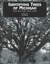

'I believe this is a tree'

----------------------------------


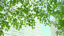

'I believe this is a tree'

----------------------------------


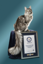

'I believe this is a cat'

----------------------------------


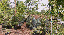

'I believe this is a tree'

----------------------------------


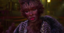

'I believe this is a cat'

----------------------------------


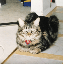

'I believe this is a cat'

----------------------------------


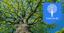

'I believe this is a tree'

----------------------------------


In [45]:
# Part 3 - Making new predictions
import numpy as np
from keras.preprocessing import image

files = os.listdir(basepath_single_prediction)

# list the categories that were trained (cat, elvis, dog etc)
classifications=training_set.class_indices
print ("I trained these classifications:", classifications)

# now iterate through all the images we want analysed in the single_prediction folder and predict their classification
for file in files:
    # predict and save result
    test_image = image.load_img(f'{basepath_single_prediction}/{file}', target_size = (64, 64), grayscale=False)
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = classifier.predict(test_image)

    # see what folder name (class) the result belongs to
    prediction = "no idea"
    index = result[0][0]
    if index % 1 == 0:
        classification = class_names[int(result[0][0])]
        prediction = f'I believe this is a {classification}'

    # show the image and the prediction
    pil_im = Image.open(f'{basepath_single_prediction}/{file}')
    pil_im.thumbnail((64,64))
    display(pil_im, prediction)
    print ('----------------------------------')
